In [2]:
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight


from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.layers import PReLU

import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from medpy.io import load
import numpy as np

#import cv2
import nibabel as nib
from PIL import Image


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         val=os.path.join(dirname, filename)
#         test_mask=np.load(val)
#         test_mask = to_categorical(test_mask , num_classes = 4)
#         print(test_mask.shape)
#         print(temp.shape())
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_img_dir = "/kaggle/input/brats701515/input_data_128/train/images/"
train_mask_dir = "/kaggle/input/brats701515/input_data_128/train/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list =  sorted(os.listdir(train_mask_dir))


In [4]:
batch_size = 2
# print(train_img_list,train_mask_list)

In [5]:
def load_img(img_dir , img_list):
    
    images = []
    for i,image_name in enumerate(img_list):
        
        if(image_name.split('.')[1]=='npy'):
            # if the file is numpy array
            
            image = np.load(img_dir + image_name)
            images.append(image)
        
    images = np.array(images)
        
    return (images)

In [6]:
def imageLoader(img_dir , img_list , mask_dir , mask_list , batch_size):
    
    L = len(img_list)
    
    while True:
        
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            
            limit = min(batch_end , L)
            
            X = load_img(img_dir , img_list[batch_start:limit]) # load image
            Y = load_img(mask_dir , mask_list[batch_start:limit]) # load mask
            
            yield(X,Y) # yeilds images - a tuple with 2 numpy arrays with batch_size samples
            
            batch_start += batch_size
            batch_end += batch_size

In [7]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,  train_mask_dir, train_mask_list, batch_size)

In [8]:
img, msk = train_img_datagen.__next__()

In [9]:
img.shape

(2, 128, 128, 128, 3)

In [10]:
msk.shape

(2, 128, 128, 128, 4)

In [11]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

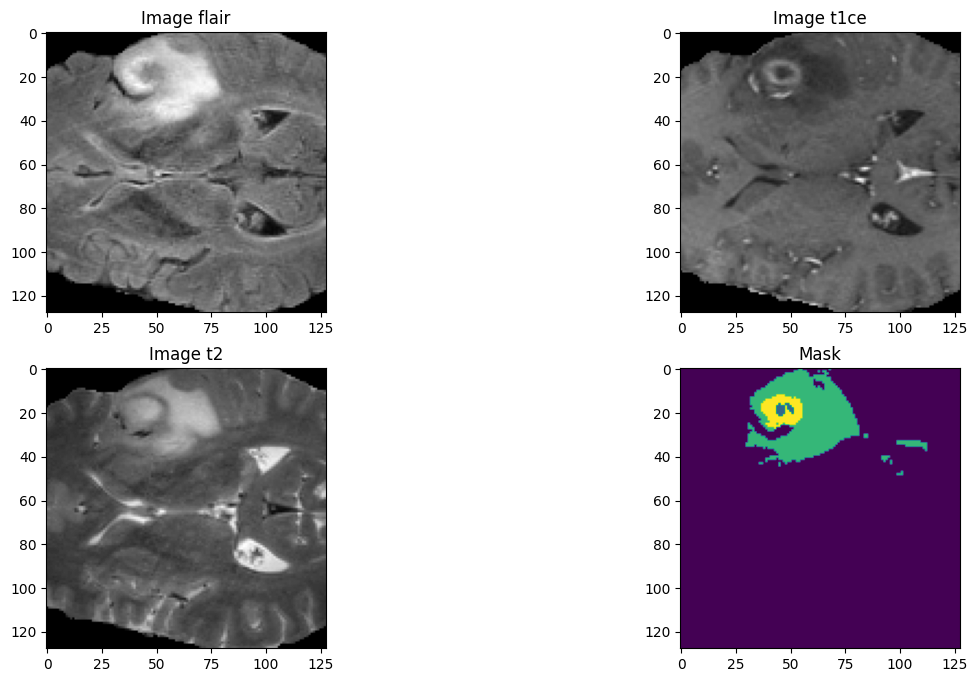

In [12]:
n_slice=random.randint(0, test_mask.shape[2])
n_slice=55
plt.figure(figsize=(15, 8))


plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [13]:
class SingleDeconv3DBlock(tf.keras.layers.Layer):

    def __init__(self,filters):
        super(SingleDeconv3DBlock, self).__init__()
        self.block = tf.keras.layers.Conv3DTranspose(filters= filters, 
                                                     kernel_size=2, strides=2, 
                                                     padding="valid", 
                                                     output_padding=None)
                                                     

    def call(self, inputs):        
        return self.block(inputs)



class SingleConv3DBlock(tf.keras.layers.Layer):

    def __init__(self, filters,kernel_size):
        super(SingleConv3DBlock, self).__init__()
        self.kernel=kernel_size
        self.res = tuple(map(lambda i: (i - 1)//2, self.kernel))
        self.block = tf.keras.layers.Conv3D(filters= filters, 
                                            kernel_size=kernel_size, 
                                            strides=1, 
                                            padding='same')

    def call(self, inputs):
        return self.block(inputs)
    
class Conv3DBlock(tf.keras.layers.Layer):

    def __init__(self, filters,kernel_size=(3,3,3)):
        super(Conv3DBlock, self).__init__()
        self.a= tf.keras.Sequential([
                                     SingleConv3DBlock(filters,kernel_size=kernel_size),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Activation('relu')
        ])
        

    def call(self, inputs):
        return self.a(inputs)
    
class Deconv3DBlock(tf.keras.layers.Layer):

    def __init__(self, filters,kernel_size=(3,3,3)):
        super(Deconv3DBlock, self).__init__()
        self.a= tf.keras.Sequential([
                                     SingleDeconv3DBlock(filters=filters),
                                     SingleConv3DBlock(filters=filters,kernel_size=kernel_size),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Activation('relu')
        ])
  
    def call(self, inputs):
        return self.a(inputs)

In [17]:
class SelfAttention(tf.keras.layers.Layer):

    def __init__(self, num_heads,embed_dim,dropout):
        super(SelfAttention, self).__init__()

        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query=tf.keras.layers.Dense(self.all_head_size)
        self.key = tf.keras.layers.Dense(self.all_head_size)
        self.value = tf.keras.layers.Dense(self.all_head_size)                

        self.out=tf.keras.layers.Dense(embed_dim)
        self.attn_dropout=tf.keras.layers.Dropout(dropout)
        self.proj_dropout=tf.keras.layers.Dropout(dropout)

        self.softmax=tf.keras.layers.Softmax()

        self.vis=False

    def transpose_for_scores(self,x):
        new_x_shape=list(x.shape[:-1] + (self.num_attention_heads, self.attention_head_size))
        new_x_shape[0] = -1
        y = tf.reshape(x, new_x_shape)
        return tf.transpose(y,perm=[0,2,1,3])

    def call(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)  
        attention_scores= query_layer @ tf.transpose(key_layer,perm=[0,1,3,2])
        attention_scores= attention_scores/math.sqrt(self.attention_head_size)
        attention_probs=self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer= attention_probs @ value_layer
        context_layer=tf.transpose( context_layer, perm=[0,2,1,3])
        new_context_layer_shape = list(context_layer.shape[:-2] + (self.all_head_size,))
        new_context_layer_shape[0]= -1
        context_layer = tf.reshape(context_layer,new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights     

In [18]:
class Mlp(tf.keras.layers.Layer):

    def __init__(self, output_features, drop=0.):
        super(Mlp, self).__init__()
        self.a=tf.keras.layers.Dense(units=output_features,activation=tf.nn.gelu)
        self.b=tf.keras.layers.Dropout(drop)

    def call(self, inputs):
        x=self.a(inputs)
        return self.b(x)

class PositionwiseFeedForward(tf.keras.layers.Layer):

    def __init__(self, d_model=768,d_ff=2048, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.a=tf.keras.layers.Dense(units=d_ff)
        self.b=tf.keras.layers.Dense(units=d_model)
        self.c=tf.keras.layers.Dropout(dropout)

    def call(self, inputs):
        return self.b(self.c(tf.nn.relu(self.a(inputs))))

##embeddings, projection_dim=embed_dim
class PatchEmbedding(tf.keras.layers.Layer): 
      def __init__(self ,  cube_size, patch_size , embed_dim):
        super(PatchEmbedding, self).__init__()
        self.num_of_patches=int((cube_size[0]*cube_size[1]*cube_size[2])/(patch_size*patch_size*patch_size))
        self.patch_size=patch_size
        self.size = patch_size
        self.embed_dim = embed_dim

        self.projection = tf.keras.layers.Dense(embed_dim)

        self.clsToken = tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 512 , embed_dim)) , trainable=True)

        self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , embed_dim)
        self.patches=None
        self.lyer = tf.keras.layers.Conv3D(filters= self.embed_dim,kernel_size=self.patch_size, strides=self.patch_size,padding='valid')
        #embedding - basically is adding numerical embedding to the layer along with an extra dim  
      
      def call(self , inputs):
        patches =self.lyer(inputs)
        patches = tf.reshape(patches , (tf.shape(inputs)[0] , -1 , self.size * self.size * 3))
        patches = self.projection(patches)
        positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
        positionalEmbedding = self.positionalEmbedding(positions)
        patches = patches + positionalEmbedding

        return patches, positionalEmbedding

In [19]:
##transformerblock
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self ,  embed_dim, num_heads ,dropout, cube_size, patch_size):
      super(TransformerLayer,self).__init__()

      self.attention_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

      self.mlp_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

#embed_dim/no-of_heads
      self.mlp_dim = int((cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
      
      self.mlp = PositionwiseFeedForward(embed_dim,2048)
      self.attn = SelfAttention(num_heads, embed_dim, dropout)
    
    def call(self ,x  , training=True):
      h=x
      x=self.attention_norm(x)
      x,weights= self.attn(x)
      x=x+h
      h=x

      x = self.mlp_norm(x)
      x = self.mlp(x)

      x = x + h

      return x, weights


class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self ,embed_dim , num_heads,cube_size, patch_size , num_layers=12 , dropout=0.1,extract_layers=[3,6,9,12]):
    super(TransformerEncoder,self).__init__()
#  embed_dim, num_heads ,dropout, cube_size, patch_size
    self.embeddings = PatchEmbedding(cube_size,patch_size, embed_dim)
    self.extract_layers =extract_layers
    self.encoders = [TransformerLayer(embed_dim, num_heads,dropout, cube_size, patch_size) for _ in range(num_layers)]
  
  def call(self , inputs , training=True):
    extract_layers = []
    x = inputs
    x,_=self.embeddings(x)
    
    for depth,layer in enumerate(self.encoders):
      x,_= layer(x , training=training)
      if depth + 1 in self.extract_layers:
                extract_layers.append(x)
    
    return extract_layers

In [28]:
import tensorflow as tf
import math
class UNETR(tf.keras.Model):
    def __init__(self, img_shape=(128,128,128), input_dim=3, output_dim=4, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super(UNETR, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]
        
        self.patch_dim = [int(x / patch_size) for x in img_shape]
        self.transformer = TransformerEncoder(
            self.embed_dim,
            self.num_heads,
            self.img_shape,
            self.patch_size,
            self.num_layers,
            self.dropout,
            self.ext_layers
        )
        
        # U-Net Decoder
        self.decoder0 = tf.keras.Sequential([
            Conv3DBlock(32, (3,3,3)),
            Conv3DBlock(64, (3,3,3))
        ])
      
        self.decoder3 = tf.keras.Sequential([
            Deconv3DBlock(512),
            Deconv3DBlock(256),
            Deconv3DBlock(128)
        ])
   
        self.decoder6 = tf.keras.Sequential([
            Deconv3DBlock(512),
            Deconv3DBlock(256)
        ])
    
        self.decoder9 = Deconv3DBlock(512)

        self.decoder12_upsampler = SingleDeconv3DBlock(512)

        self.decoder9_upsampler = tf.keras.Sequential([
            Conv3DBlock(512),
            Conv3DBlock(512),
            Conv3DBlock(512),
            SingleDeconv3DBlock(256)
        ])

        self.decoder6_upsampler = tf.keras.Sequential([
            Conv3DBlock(256),
            Conv3DBlock(256),
            SingleDeconv3DBlock(128)
        ])

        self.decoder3_upsampler = tf.keras.Sequential([
            Conv3DBlock(128),
            Conv3DBlock(128),
            SingleDeconv3DBlock(64)
        ])

        self.decoder0_header = tf.keras.Sequential([
            Conv3DBlock(64),
            Conv3DBlock(64),
            SingleConv3DBlock(output_dim, (1,1,1))
        ])

    def call(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, z[0], z[1], z[2], z[3]
        z3 = tf.reshape(tf.transpose(z3, perm=[0,2,1]), [-1, *self.patch_dim, self.embed_dim])
        z6 = tf.reshape(tf.transpose(z6, perm=[0,2,1]), [-1, *self.patch_dim, self.embed_dim])
        z9 = tf.reshape(tf.transpose(z9, perm=[0,2,1]), [-1, *self.patch_dim, self.embed_dim])
        z12 = tf.reshape(tf.transpose(z12, perm=[0,2,1]), [-1, *self.patch_dim, self.embed_dim])
        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(tf.concat([z9, z12], 4))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(tf.concat([z6, z9], 4))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(tf.concat([z3, z6], 4))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(tf.concat([z0, z3], 4))
        return output

    def build_graph(self):
        x = tf.keras.Input(shape=(self.img_shape[0], self.img_shape[1], self.img_shape[2], self.input_dim))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

    def summary(self):
        model = self.build_graph()
        return model.summary()

# Example usage
model = UNETR()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 transformer_encoder_6 (Transfo  [(None, 512, 768),  76982784    ['input_3[0][0]']                
 rmerEncoder)                    (None, 512, 768),                                                
                                 (None, 512, 768),                                                
                                 (None, 512, 768)]                                                
                                                                                            

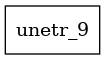

In [35]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Ensure the UNETR class and all required components are defined above this point

# Build the model by calling it with an input tensor
input_shape = (128, 128, 128, 3)
unetr_model = UNETR(img_shape=input_shape[:-1], input_dim=input_shape[-1])
inputs = tf.keras.Input(shape=input_shape)
_ = unetr_model(inputs)  # Build the model by calling it

# Plot the model
plot_model(
    unetr_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


In [36]:
img_list = sorted(os.listdir(train_img_dir))
print(len(img_list))
msk_list = sorted(os.listdir(train_mask_dir))
print(len(msk_list))


240
240


In [38]:
num_images = len(os.listdir(train_img_dir))

In [39]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

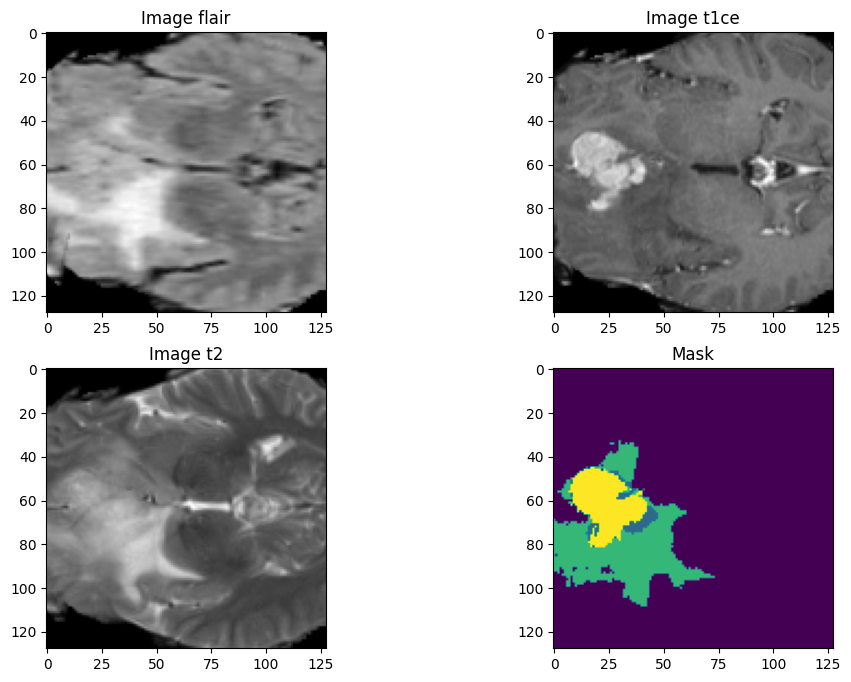

In [40]:
# n_slice=random.randint(0, test_mask.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [41]:
val_img_dir = "/kaggle/input/brats701515/input_data_128/val/images/"
val_mask_dir = "/kaggle/input/brats701515/input_data_128/val/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))
print(len(os.listdir(val_img_dir)))
print(len(os.listdir(val_mask_dir)))

51
51


In [45]:
batch_size=2
train_img_datagen = imageLoader(train_img_dir, train_img_list,  train_mask_dir, train_mask_list, batch_size)
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [46]:
img, msk = train_img_datagen.__next__() 
img.shape
msk.shape

(2, 128, 128, 128, 4)

In [48]:
!pip install classification-models-3D==1.0.7
!pip install keras-applications==1.0.8
!pip install segmentation-models-3D==1.0.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00


In [52]:
import tensorflow as tf
import tensorflow.keras as keras
import segmentation_models_3D as sm
import tensorflow_addons as tfa

In [53]:
steps_per_epoch = (len(train_img_list)//batch_size )+1
val_steps_per_epoch =( len(val_img_list)//batch_size )+1 

Defining the loss function and the optimizer function

In [54]:
wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21

In [55]:
import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
cce = sm.losses.CategoricalCELoss()
combined_loss = dice_loss + cce

# mean_iou = tf.keras.metrics.MeanIoU(num_classes=4)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.MeanIoU(num_classes=4)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)
print(1)

1


In [56]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, name='dice_loss'):
        super(DiceLoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        smooth = 1e-15
        dice = 0
        num_classes = y_pred.shape[-1]
        for c in range(num_classes):
            intersection = tf.reduce_sum(y_true[..., c] * y_pred[..., c])
            union = tf.reduce_sum(y_true[..., c]) + tf.reduce_sum(y_pred[..., c])
            dice += (2. * intersection + smooth) / (union + smooth)
        return 1.0 - dice / num_classes

class TverskyLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5, name='tversky_loss'):
        super(TverskyLoss, self).__init__(name=name)
        self.alpha = alpha
        self.beta = beta

    def call(self, y_true, y_pred):
        smooth = 1e-15
        tversky = 0
        num_classes = y_pred.shape[-1]
        for c in range(num_classes):
            true_positives = tf.reduce_sum(y_true[..., c] * y_pred[..., c])
            false_negatives = tf.reduce_sum(y_true[..., c] * (1 - y_pred[..., c]))
            false_positives = tf.reduce_sum((1 - y_true[..., c]) * y_pred[..., c])
            tversky += (true_positives + smooth) / (true_positives + self.alpha * false_negatives + self.beta * false_positives + smooth)
        return 1.0 - tversky / num_classes

# Assuming SoftBCEWithLogitsLoss is just binary cross-entropy
BCELoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# You can define alpha and beta here if you want to use TverskyLoss
alpha = 0.5
beta = 1 - alpha

# Define the loss function according to your preference
# You can uncomment and modify this based on your desired combination
def criterion(y_true, y_pred):
#     return BCELoss(y_true, y_pred)
    # return 0.5 * BCELoss(y_true, y_pred) + 0.5 * DiceLoss()(y_true, y_pred)
    return 0.5 * BCELoss(y_true, y_pred) + 0.5 * TverskyLoss(alpha, beta)(y_true, y_pred)


In [57]:
model.compile(optimizer = optim, loss=criterion, metrics=metrics)
# print(model.summary())
print(2)

2


In [58]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=75,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/75


ResourceExhaustedError: Graph execution error:

Detected at node 'unetr_8/sequential_215/conv3d_block_98/sequential_214/single_conv3d_block_160/conv3d_169/Conv3D' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32/844459932.py", line 1, in <module>
      history=model.fit(train_img_datagen,
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_32/3562304270.py", line 88, in call
      output = self.decoder0_header(tf.concat([z0, z3], 4))
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_32/3344474311.py", line 42, in call
      return self.a(inputs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_32/3344474311.py", line 28, in call
      return self.block(inputs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'unetr_8/sequential_215/conv3d_block_98/sequential_214/single_conv3d_block_160/conv3d_169/Conv3D'
Detected at node 'unetr_8/sequential_215/conv3d_block_98/sequential_214/single_conv3d_block_160/conv3d_169/Conv3D' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32/844459932.py", line 1, in <module>
      history=model.fit(train_img_datagen,
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_32/3562304270.py", line 88, in call
      output = self.decoder0_header(tf.concat([z0, z3], 4))
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_32/3344474311.py", line 42, in call
      return self.a(inputs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_32/3344474311.py", line 28, in call
      return self.block(inputs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'unetr_8/sequential_215/conv3d_block_98/sequential_214/single_conv3d_block_160/conv3d_169/Conv3D'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[2,64,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node unetr_8/sequential_215/conv3d_block_98/sequential_214/single_conv3d_block_160/conv3d_169/Conv3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/pivot_f/_31/_577]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[2,64,128,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node unetr_8/sequential_215/conv3d_block_98/sequential_214/single_conv3d_block_160/conv3d_169/Conv3D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_80992]

In [ ]:
import csv

# Assuming you have trained your model and obtained a history object

# Define a list to store training results
training_results = []

# Extract training metrics from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
training_accuracy = history.history['accuracy']
training_iou_score = history.history['iou_score']
training_mean_iou = history.history['mean_io_u']  # Adjust the metric name as needed


# validation_results = []

# Extract validation metrics from the history object (assuming it contains validation data)
validation_accuracy = history.history['val_accuracy']
validation_iou_score = history.history['val_iou_score']
validation_mean_iou = history.history['val_mean_io_u']  # Adjust the metric name as needed

# Append the training results to the list
for epoch, training_acc, training_iou_score, training_miou, val_acc, val_iou_score, val_miou in zip(epochs, training_accuracy, training_iou_score,training_mean_iou, validation_accuracy, validation_iou_score, validation_mean_iou):
    training_results.append([epoch, training_acc, training_iou_score, training_miou, val_acc, val_iou_score, val_miou])

# Define the training CSV file path
training_csv_file = '/kaggle/working/training_and_val_metrics.csv'

# Write the training results to a CSV file
with open(training_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training accuracy', 'Training iou_score', 'Training Mean IOU',  'Validation accuracy', 'Validation iou_score', 'Validation Mean IOU'])
    writer.writerows(training_results)

print(f'Training results saved to {training_csv_file}')


In [ ]:
test_img_dir = "/kaggle/input/brats701515/input_data_128/test/images/"
test_mask_dir = "/kaggle/input/brats701515/input_data_128/test/masks/"

test_img_list = sorted(os.listdir(test_img_dir))
test_mask_list = sorted(os.listdir(test_mask_dir))

batch_size=2
test_img_datagen = imageLoader(test_img_dir, test_img_list,  test_mask_dir, test_mask_list, batch_size)
test_steps_per_epoch =(len(test_img_list)//batch_size )+1 

In [ ]:
test_loss, test_accuracy, iou_score, mean_iou = model.evaluate(
    test_img_datagen, 
    steps = test_steps_per_epoch, 
    verbose=1
)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test IoU Score: {iou_score}')
print(f'Test Mean IoU: {mean_iou}')


In [ ]:
import csv

# Define the test results
test_results = [
    ['Test Loss', test_loss],
    ['Test Accuracy', test_accuracy],
    ['Test IoU Score', iou_score],
    ['Test Mean IoU', mean_iou]
]

# Define the CSV file path
test_csv_file = '/kaggle/working/test_results.csv'

# Write the test results to a CSV file
with open(test_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(test_results)

print(f'Test results saved to {test_csv_file}')


In [ ]:
def dice_score(o, t, eps=1e-8):
    num = 2*(o*t).sum() + eps
    den = o.sum() + t.sum() + eps
    return num/den

def softmax_output_dice(target,output):
    ret = []
    
    # whole   wt
    o = output > 0; t = target > 0 # ce
    ret += dice_score(o, t),
    
    # core   tc
    o = (output == 1) | (output == 3)
    t = (target == 1) | (target == 3)
    ret += dice_score(o, t),
    
    # active   et
    o = (output == 3);t = (target == 3)
    ret += dice_score(o, t),

    return ret


dice_scores_wt = []
dice_scores_tc = []
dice_scores_et = []
num_classes = 4

for batch in range(test_steps_per_epoch):
    
    test_img, test_mask = next(test_img_datagen)
    test_prediction = model.predict(test_img)
    
    test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
    
    tensor = softmax_output_dice(test_mask_argmax, test_prediction_argmax)
    dice_batch = tensor[0]
    dice_scores_wt.append(dice_batch)
    dice_scores_tc.append(tensor[1])
    dice_scores_et.append(tensor[2])


print("Dice Scores for Unet trained for 150 epochs with dice loss and focal loss:")
average_dice_score_et = sum(dice_scores_et) / len(dice_scores_et)
print("Average Dice Score et:", average_dice_score_et)
average_dice_score_wt = sum(dice_scores_wt) / len(dice_scores_wt)
print("Average Dice Score wt:", average_dice_score_wt)
average_dice_score_tc = sum(dice_scores_tc) / len(dice_scores_tc)
print("Average Dice Score tc:", average_dice_score_tc)



import csv

# Define the test results
average_dice_scores = [
    ['Enhanced Tumor', average_dice_score_et],
    ['Whole Tumor', average_dice_score_wt],
    ['Tumor Core', average_dice_score_tc]
]

# Define the CSV file path
test_csv_file = '/kaggle/working/dice_scores.csv'

# Write the test results to a CSV file
with open(test_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(average_dice_scores)

print(f'dice scores results saved to {test_csv_file}')


In [ ]:
model.save('/kaggle/working/u_net_dice_loss_150.hdf5')

In [ ]:
# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), mean_iou]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['mean_io_u']
val_acc = history.history['val_mean_io_u']

plt.plot(epochs, acc, 'y', label='Training mean_iou')
plt.plot(epochs, val_acc, 'r', label='Validation mean_iou')
plt.title('Training and validation mean_iou')
plt.xlabel('Epochs')
plt.ylabel('mean_iou')
plt.legend()
plt.show()

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training iou_score')
plt.plot(epochs, val_acc, 'r', label='Validation iou_score')
plt.title('Training and validation iou_score')
plt.xlabel('Epochs')
plt.ylabel('iou_score')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from keras.losses import Loss
from keras.utils import get_custom_objects
get_custom_objects().update({"criterion": criterion})


get_custom_objects().update({"iou_score": sm.metrics.IOUScore(threshold=0.5)})

get_custom_objects().update({"mean_iou_score": tf.keras.metrics.MeanIoU(num_classes=4)})

In [ ]:
my_model = load_model('/kaggle/working/u_net_dice_loss_150.hdf5')

In [ ]:
# my_model = load_model('/kaggle/working/brats_3d_new.hdf5')
img_num = 82

test_img = np.load("/kaggle/input/brats701515/input_data_128/test/images/image_"+str(img_num)+".npy")

test_mask = np.load("/kaggle/input/brats701515/input_data_128/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_mask_argmax))
print(np.unique(test_prediction_argmax))

In [ ]:
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()